In [1]:
import pandas as pd
import numpy as np
import pyspark as ps
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
rating_dt = pd.read_csv('D:/Columbia/fall 2020/IEOR 4571/HW2/ml-latest/ratings.csv')

In [3]:
tag_dt = pd.read_csv('D:/Columbia/fall 2020/IEOR 4571/HW2/ml-latest/tags.csv')

In [4]:
movie_dt = pd.read_csv('D:/Columbia/fall 2020/IEOR 4571/HW2/ml-latest/movies.csv')

In [5]:
print(tag_dt.head(5))
print(rating_dt.head(5))
print(movie_dt.head(5))

   userId  movieId           tag   timestamp
0      14      110          epic  1443148538
1      14      110      Medieval  1443148532
2      14      260        sci-fi  1442169410
3      14      260  space action  1442169421
4      14      318  imdb top 250  1442615195
   userId  movieId  rating   timestamp
0       1      307     3.5  1256677221
1       1      481     3.5  1256677456
2       1     1091     1.5  1256677471
3       1     1257     4.5  1256677460
4       1     1449     4.5  1256677264
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  

In [6]:
rating_dt.shape

(27753444, 4)

In [7]:
# filter out movies that has less than 100 rates
movie_rating_count = rating_dt.groupby(['movieId']).size().reset_index(name='Mcount')
movie_poll = movie_rating_count[movie_rating_count.Mcount > 100].movieId

In [8]:
# sample 1000 items from movie poll 
movie_sample = movie_poll.sample(1000, replace=False, random_state=1).values.reshape(-1, 1)

# get rating and users of sampled movies
sample_movie_rating = rating_dt.loc[rating_dt['movieId'].isin(movie_sample)]

In [9]:
user_poll = np.unique(sample_movie_rating['userId'])

In [10]:
np.random.seed(1)
user_test = np.random.choice(user_poll, 1000)

In [11]:
test_user_rating = sample_movie_rating.loc[sample_movie_rating['userId'].isin(user_test)]

In [12]:
#sample_matrix = test_user_rating.pivot(index = 'movieId',
#                                       columns = 'userId', 
#                                       values='rating').fillna(0)
#sample_matrix_cp = csr_matrix(sample_matrix)

In [13]:
# pivot movie, user, rating dataframe into compressed matrix
#
def movie_use_matrix_pivot(df_):
    mu_matrix = df_.pivot(index = 'movieId', 
                          columns = 'userId', 
                          values = 'rating').fillna(0)
    # compress original matrix
    mu_matrix_cp = csr_matrix(mu_matrix.values)
    return mu_matrix, mu_matrix_cp

In [14]:
# input: compressed movie-user matrix, distance method, number of nearest neighbors
# default distance method is adjusted cosine, default neighbor is 5
# output: a pre-trained KNN model
#
def knn_model_fit(mu_matrix_cp, dist_='cosine', n_neighbor_=5):
    # use adjusted cosine distance to find k nearest item 
    # default k-neighbor is 5
    knn = NearestNeighbors(metric=dist_, algorithm='brute', n_neighbors=n_neighbor_, n_jobs=-1)
    knn.fit(mu_matrix_cp)
    return knn

In [16]:
# test function
sample_matrix, sample_matrix_cp = movie_use_matrix_pivot(test_user_rating)
sample_matrix_knn = knn_model_fit(sample_matrix_cp, 'cosine', 5)

distance1, indices1 = sample_matrix_knn.kneighbors(sample_matrix.loc[sample_matrix.index == 34])
#distance2, indices2 = single_recommendation(sample_matrix_knn, sample_matrix, 34)
#assert(np.alltrue(indices1 == indices2))

In [17]:
# input: rating dataset, userid, a rating threshold, movies that are rated below threshold
# will not be counted 
# output: a list of high-scored movies that are rated by givern user, a list of corresponding ratings
#
def get_rated_movies(data, userid, threshold=2):
    all_rates = data[data['userId'] == userid]
    high_rates = all_rates[all_rates['rating'] >= threshold]['rating'].values
    high_rate_movie = all_rates[all_rates['rating'] >= threshold]['movieId'].values
    return high_rate_movie, high_rates

In [157]:
# make recommendations
def opt_recommend(mu_matrix,dist,ind,data):
    movielist = mu_matrix.index.tolist()
    userIds = data.userId.unique()
    recommendation = []

    for Id in userIds:
        m, r = get_rated_movies(data, Id, 2)
        if len(m) > 1:

            distance_list = []
            recommend_list = []

            for movieId in m:
                distances=dist[movielist.index(movieId)]
                indices=ind[movielist.index(movieId)]

                distances = distances/ r[np.where(m == movieId)].tolist()
                movie_list = matrix_5.index[indices.reshape(-1)].tolist()

                if movieId == movie_list[0]:
                    distances = distances[1:]
                    movie_list = movie_list[1:]

                distance_list.extend(distances)
                recommend_list.extend(movie_list)

            recommend_list = np.array(recommend_list)

            if recommend_list.shape[0] <= 20:
                recommendation.extend(recommend_list)
            else:
                sorted_recommend = recommend_list[np.array(distance_list).argsort()]
                recommendation.extend(sorted_recommend[:20])
        
    return recommendation


In [195]:
# calculate HitRate
def opt_HitRate(mu_matrix, dist, ind,data):
    movielist = mu_matrix.index.tolist()
    userIds = data.userId.unique()
    hits = 0
    total = 0

    for Id in userIds:
        m, r = get_rated_movies(data, Id, 2)

        if len(m) > 1:
            token = np.random.randint(len(m))
            l = m[token]
            new_movies = np.delete(m, [token])
            new_ratings = np.delete(r, [token])

            distance_list = []
            recommend_list = []

            for movieId in new_movies:
                distances=dist[movielist.index(movieId)]
                indices=ind[movielist.index(movieId)]

                distances = distances/ new_ratings[np.where(new_movies == movieId)].tolist()
                movie_list = matrix_5.index[indices.reshape(-1)].tolist()

                if movieId == movie_list[0]:
                    distances = distances[1:]
                    movie_list = movie_list[1:]

                distance_list.extend(distances)
                recommend_list.extend(movie_list)

            recommend_list = np.array(recommend_list)

            if recommend_list.shape[0] <= 20:
                if l in recommend_list:
                    hits += 1
            else:
                sorted_recommend = recommend_list[np.array(distance_list).argsort()]
                if l in sorted_recommend[:20]:
                    hits += 1
            total += 1

    return hits/total

## Test on different Neighborhood Sizes

In [173]:
# n_neighbor = 2
knn_2neighbors = knn_model_fit(sample_matrix_cp, 'cosine',2)
dist_2neighbors, ind_2neighbors = knn_2neighbors.kneighbors(sample_matrix)
hit_rate_2neighbors = opt_HitRate(sample_matrix,dist_2neighbors, ind_2neighbors, test_user_rating)

In [175]:
print(hit_rate_2neighbors)

0.031806615776081425


In [176]:
# n_neighbor = 3
knn_3neighbors = knn_model_fit(sample_matrix_cp, 'cosine',3)
dist_3neighbors, ind_3neighbors = knn_3neighbors.kneighbors(sample_matrix)
hit_rate_3neighbors = opt_HitRate(sample_matrix,dist_3neighbors, ind_3neighbors, test_user_rating)

In [192]:
print(hit_rate_3neighbors)

0.04834605597964377


In [221]:
# n_neighbor = 4
knn_4neighbors = knn_model_fit(sample_matrix_cp, 'cosine',4)
dist_4neighbors, ind_4neighbors = knn_4neighbors.kneighbors(sample_matrix)
hit_rate_4neighbors = opt_HitRate(sample_matrix,dist_4neighbors, ind_4neighbors, test_user_rating)

In [222]:
print(hit_rate_4neighbors)

0.061068702290076333


In [182]:
# n_neighbor = 5
knn_5neighbors = knn_model_fit(sample_matrix_cp, 'cosine',5)
dist_5neighbors, ind_5neighbors = knn_5neighbors.kneighbors(sample_matrix)
hit_rate_5neighbors = opt_HitRate(sample_matrix,dist_5neighbors, ind_5neighbors, test_user_rating)

In [184]:
print(hit_rate_5neighbors)

0.06361323155216285


In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [223]:
hit_rate = [hit_rate_2neighbors,hit_rate_3neighbors,hit_rate_4neighbors,hit_rate_5neighbors]
x = [2,3,4,5]

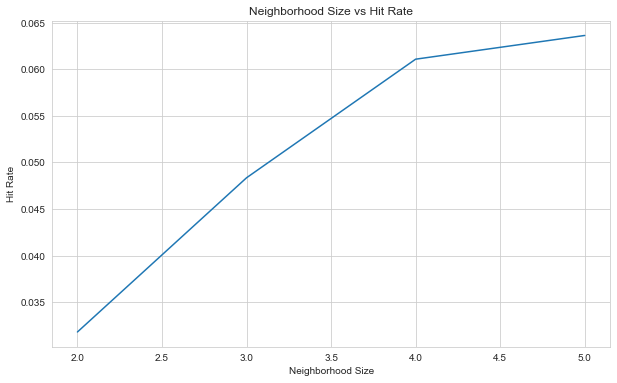

In [224]:
plt.figure(figsize=(10,6))
d = {"Neighborhood Size":x,"Hit Rate":hit_rate}
df = pd.DataFrame(d)

sns.lineplot(data = df,x = 'Neighborhood Size',y = 'Hit Rate').set_title('Neighborhood Size vs Hit Rate')

plt.show()

## Test on different sizes of data

In [26]:
movie_ratings_25 = sample_movie_rating.sample(frac = .25, random_state = 1)
movie_ratings_50 = sample_movie_rating.sample(frac = .50, random_state = 2)
movie_ratings_75 = sample_movie_rating.sample(frac = .75, random_state = 3)

In [108]:
# test 25%
matrix_25, matrix_cp_25 = movie_use_matrix_pivot(movie_ratings_25)
knn_25 = knn_model_fit(matrix_cp_25, 'cosine', 5)
dist_25, ind_25 = knn_25.kneighbors(matrix_25)
hit_rate_25 = opt_HitRate(matrix_25,dist_25, ind_25, movie_ratings_25)

In [110]:
print(hit_rate_25)

0.21218801257874775


In [111]:
# test 50%
matrix_50, matrix_cp_50 = movie_use_matrix_pivot(movie_ratings_50)
knn_50 = knn_model_fit(matrix_cp_50, 'cosine', 5)
dist_50, ind_50 = knn_50.kneighbors(matrix_50)
hit_rate_50 = opt_HitRate(matrix_50,dist_50, ind_50, movie_ratings_50)

In [113]:
print(hit_rate_50)

0.27341213050205954


In [114]:
# test 75%
matrix_75, matrix_cp_75 = movie_use_matrix_pivot(movie_ratings_75)
knn_75 = knn_model_fit(matrix_cp_75, 'cosine', 5)
dist_75, ind_75 = knn_75.kneighbors(matrix_75)
hit_rate_75 = opt_HitRate(matrix_75,dist_75, ind_75, movie_ratings_75)

In [116]:
print(hit_rate_75)

0.30219783562160485


In [119]:
# test 100%
matrix_100, matrix_cp_100 = movie_use_matrix_pivot(sample_movie_rating)
knn_100 = knn_model_fit(matrix_cp_100, 'cosine', 5)
dist_100, ind_100 = knn_100.kneighbors(matrix_100)
hit_rate_100 = opt_HitRate(matrix_100,dist_100, ind_100, sample_movie_rating)

In [122]:
print(hit_rate_100)

0.3205409993036212


In [190]:
hit_rate = [hit_rate_25,hit_rate_50,hit_rate_75,hit_rate_100]
x = [.25,.5,.75,1.0]

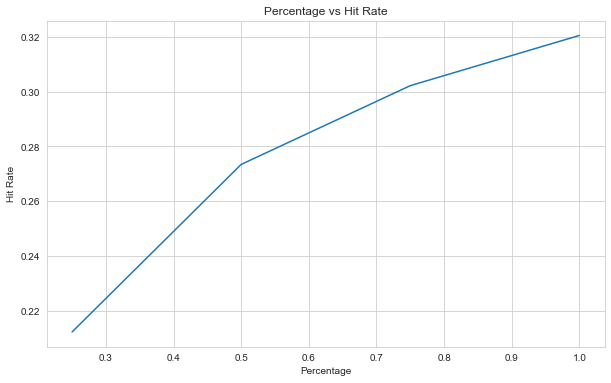

In [191]:
plt.figure(figsize=(10,6))
d = {"Percentage":x,"Hit Rate":hit_rate}
df = pd.DataFrame(d)

sns.lineplot(data = df,x = 'Percentage',y = 'Hit Rate').set_title('Percentage vs Hit Rate')
plt.show()

## Coverage

In [166]:
def coverage_cal(mu_matrix, dist, ind, data):
    rec = opt_recommend(mu_matrix,dist,ind,data)
    rec_unique = set()
    
    for item in rec:
        rec_unique.add(item)
    
    return len(rec_unique)

In [169]:
coverage = coverage_cal(matrix_100,dist_100, ind_100, sample_movie_rating)

In [171]:
print(f'Recommendation list covered {coverage} movies.')

Recommendation list covered 857 movies.
